In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np

import seaborn as sns

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from pycaret.regression import *

In [2]:
#Encoding method 1
df = pd.read_excel(r'xrd_new.xlsx', sheet_name='Sheet6')
df = df.drop(['Isc','schw 1', 'schw 2','schw 3', 'schw 4', 'schw 5', 'schw 6'], axis=1)

<AxesSubplot: >

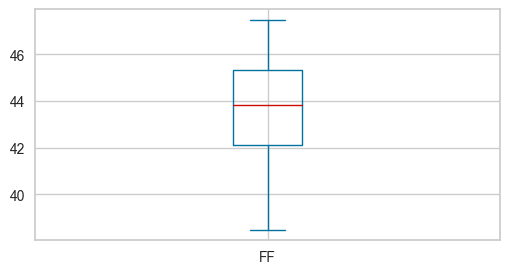

In [3]:
df["FF"].plot(kind="box", figsize=(6,3))

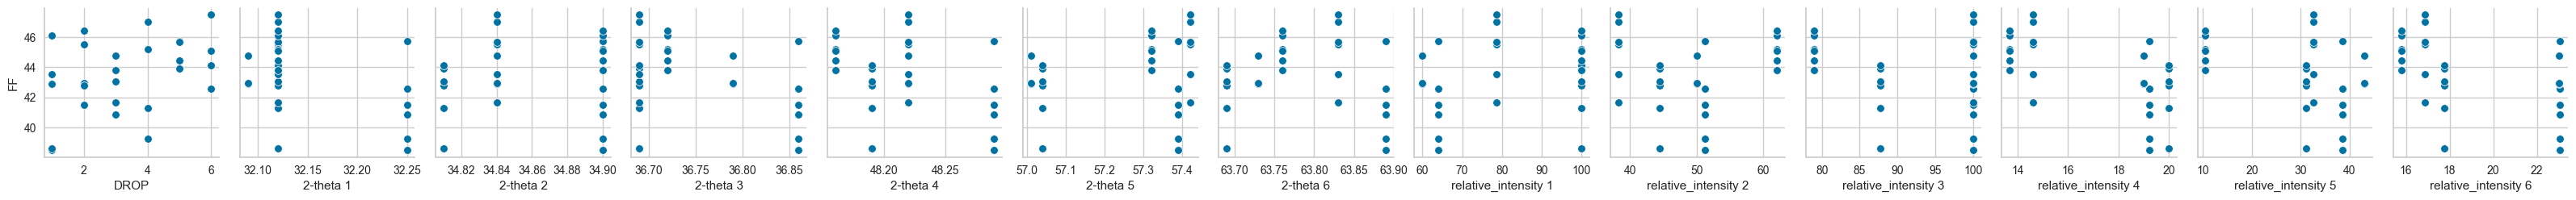

In [4]:
# ''
sns.pairplot(data=df,
                  y_vars=["FF"],
                  x_vars=["DROP", '2-theta 1', '2-theta 2', '2-theta 3', '2-theta 4',
            '2-theta 5', '2-theta 6','relative_intensity 1',
            'relative_intensity 2', 'relative_intensity 3', 'relative_intensity 4',
            'relative_intensity 5', 'relative_intensity 6'])

In [5]:
reg = setup(data=df , target = 'FF' ,normalize=True , normalize_method='minmax',train_size=0.8,fold=3
            ,keep_features=['FWHM 1', 'FWHM 2', 'FWHM 3', 'FWHM 4', 'FWHM 5',
            'FWHM 6', '2-theta 1', '2-theta 2', '2-theta 3', '2-theta 4',
            '2-theta 5', '2-theta 6','relative_intensity 1',
            'relative_intensity 2', 'relative_intensity 3', 'relative_intensity 4',
            'relative_intensity 5', 'relative_intensity 6']
            ,remove_multicollinearity = True, multicollinearity_threshold= 0.9
            , session_id=1543)

,Description,Value
0,Session id,1543
1,Target,FF
2,Target type,Regression
3,Original data shape,"(27, 26)"
4,Transformed data shape,"(27, 26)"
5,Transformed train set shape,"(21, 26)"
6,Transformed test set shape,"(6, 26)"
7,Numeric features,25
8,Keep features,18
9,Preprocess,True


In [6]:
# import RandomForestRegressor from sklearn
best = compare_models(cross_validation=False)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.4405,0.3105,0.5573,0.9556,0.0120,0.0099,0.0500
dt,Decision Tree Regressor,0.6857,0.9939,0.9969,0.8580,0.0232,0.0159,0.0300
xgboost,Extreme Gradient Boosting,0.7718,1.0272,1.0135,0.8532,0.0223,0.0175,0.1400
ada,AdaBoost Regressor,0.9582,1.1494,1.0721,0.8357,0.0242,0.0224,0.0600
rf,Random Forest Regressor,0.8802,1.1775,1.0851,0.8317,0.0257,0.0212,0.1200
et,Extra Trees Regressor,1.2853,1.7930,1.3390,0.7437,0.0307,0.0302,0.0900
lr,Linear Regression,1.2535,2.2228,1.4909,0.6823,0.0340,0.0293,0.0600
ridge,Ridge Regression,1.1977,2.3783,1.5422,0.6601,0.0359,0.0286,0.0400
huber,Huber Regressor,1.4011,2.7383,1.6548,0.6086,0.0374,0.0326,0.0200
par,Passive Aggressive Regressor,1.2048,2.8422,1.6859,0.5938,0.0397,0.0295,0.0200


In [7]:
# the coefficient of determination of the prediction.
model = create_model('gbr',cross_validation = False, return_train_score=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Test,0.4405,0.3105,0.5573,0.9556,0.0120,0.0099
Train,0.1101,0.0207,0.1438,0.9960,0.0033,0.0025


In [9]:
def wrapper(X, Y, **kwargs) -> float:
    
    input = np.array([[X, Y]])
    output = model.predict(input, **kwargs)
    output = float(output)

    if (output > -1) & (output < 100):
        return output
    
    else:
        return 10000000

In [13]:
def optimizer_instantiate(df, wrapper, pbounds, n_iter=10, kappa=5, xi=None, random_state=None):

    # df.plot(kind='scatter', x='X', y='Y', c='Z', cmap='plasma', figsize=(6,5))
    optimizer  = BayesianOptimization(wrapper, pbounds, verbose=2)

    # bo.maximize(init_points=2, n_iter=n_iter, acq='ucb', kappa=kappa)
    # plt.plot(bo.max["params"]["X"],bo.max["params"]["Y"], '*', markersize=10)
    # plt.show()
    utility = UtilityFunction(kind="ucb", kappa=kappa, xi=0)

    return optimizer, utility


def optimizer_suggest(optimizer, utility):
 
    next_point_to_probe = optimizer.suggest(utility)
    print(f"Next Point to Probe: {next_point_to_probe}")
    return next_point_to_probe

In [14]:
features = df.drop(columns=["FF"]).columns.to_list()
pbounds = {feature: (df[feature].min(), df[feature].max()) for feature in features}

# print(f"pbounds: {pbounds}")
# pbounds = {'X': (-5.0, 4.0), 'Y': (-3.0, 7.0)}
optimizer, utility = optimizer_instantiate(df, wrapper, pbounds, n_iter=100, kappa=10, xi=None, random_state=None)
optimizer.set_gp_params(alpha=1e-3)

optimizer.maximize()

|   iter    |  target   | 2-theta 1 | 2-theta 2 | 2-theta 3 | 2-theta 4 | 2-theta 5 | 2-theta 6 |   DROP    |  FWHM 1   |  FWHM 2   |  FWHM 3   |  FWHM 4   |  FWHM 5   |  FWHM 6   | Intens... | Intens... | Intens... | Intens... | Intens... | Intens... | relati... | relati... | relati... | relati... | relati... | relati... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


TypeError: wrapper() missing 2 required positional arguments: 'X' and 'Y'

### References
- https://github.com/bayesian-optimization/BayesianOptimization/blob/master/examples/advanced-tour.ipynb
- https://github.com/bayesian-optimization/BayesianOptimization/blob/master/examples/exploitation_vs_exploration.ipynb